### Importing packages

In [1]:
import os
import numpy as np
import pandas as pd
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import pandas as pd
import scipy.stats as sts 
from sklearn.decomposition import PCA
from statsmodels.multivariate.cancorr import CanCorr

from helpers import *
import cca_helpers

### Loading Data

In [7]:
data_path = r"C:\Users\alex.legariamacal\Downloads\fwcajalproject"

data_path =  '../data/'

trial_inf = trial_info(data_path + r"ab042_trial_data.csv")
neuron_inf = neuron_info(data_path + r"ab042_cluster_spike_times.csv")
spike_array = np.load(data_path + r"ab042_spikes_dense.npy")

In [8]:
print(f"Trial types: {trial_inf.trial_types}")

Trial types: ['Auditory Hit', 'Auditory Miss', 'Whisker Hit', 'Whisker Miss', 'False Alarm', 'Correct Rejection']


In [18]:
trial_type = ["Auditory Hit"]
area_1 = "tjM1"
area_2 = "DLS"

area1_spikes = filter_data(spike_array, trial_inf, neuron_inf, trial_type, [area_1, area_2])[trial_type[0]][area_1]
area2_spikes = filter_data(spike_array, trial_inf, neuron_inf, trial_type, [area_1, area_2])[trial_type[0]][area_2]



In [19]:
#Here we slice the array and we smooth

pre_win = 10
post_win = 100

kernel_size = 5


proc_area_1 = slice_array(area1_spikes, pre_win, post_win, smooth=True, smooth_kernel = kernel_size)
proc_area_2 = slice_array(area2_spikes, pre_win, post_win, smooth=True, smooth_kernel = kernel_size)

In [20]:
print(proc_area_1.shape)
print(proc_area_2.shape)

(166, 83, 110)
(135, 83, 110)


In [28]:
area1_tr, area1_te = split_reshape(proc_area_1)
area2_tr, area2_te = split_reshape(proc_area_1)

n_trials = int(proc_area_1.shape[1]//2)
print(n_trials)

41


In [29]:
print(f"Area1 train: {area1_tr.shape}, Area1 test: {area1_te.shape}")
print(f"Area2 train: {area2_tr.shape}, Area2 test: {area2_te.shape}")

Area1 train: (166, 4510), Area1 test: (166, 4510)
Area2 train: (166, 4510), Area2 test: (166, 4510)


In [30]:
#Here we mean center the data

X1_tr = area1_tr - area1_tr.mean(axis=1)[:,np.newaxis]
X1_te = area1_te - area1_tr.mean(axis=1)[:,np.newaxis]
X2_tr = area2_tr - area2_tr.mean(axis=1)[:,np.newaxis]
X2_te = area2_te - area2_tr.mean(axis=1)[:,np.newaxis]

### Getting ready for CCA

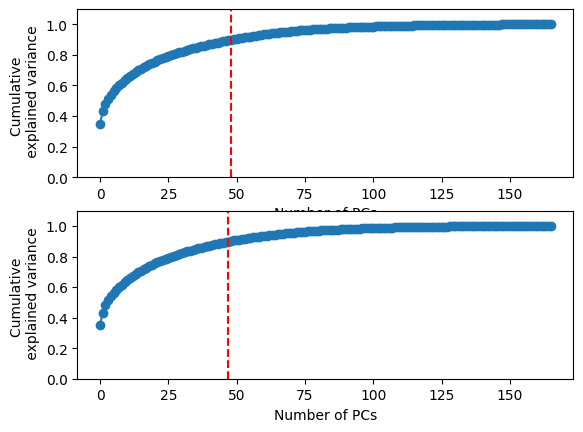

In [53]:
#Here we find the number of PCs that need to be kept

pca1 = PCA()
pca1.fit(X1_tr.T)
P_1_te = pca1.transform(X1_te.T)

pca2 = PCA()
pca2.fit(X2_tr.T)
P_2_te = pca2.transform(X2_te.T)


fig, axs = plt.subplots(2,1)
for ax in axs.flat:
    ax.set_ylim(0,1.1)
    ax.set_ylabel('Cumulative \n explained variance')
    ax.set_xlabel('Number of PCs')
    
axs[0].plot(np.cumsum(pca1.explained_variance_ratio_), marker="o")
axs[0].axvline(np.argmin(np.abs(np.cumsum(pca1.explained_variance_ratio_)-0.9)), linestyle="--", c="red")
axs[1].plot(np.cumsum(pca2.explained_variance_ratio_), marker="o")
axs[1].axvline(np.argmin(np.abs(np.cumsum(pca2.explained_variance_ratio_)-0.9)), linestyle="--", c="red")

c = max(np.argmin(np.abs(np.cumsum(pca1.explained_variance_ratio_)-0.9)), 
               np.argmin(np.abs(np.cumsum(pca2.explained_variance_ratio_)-0.9)))


### CCA

Input: (4510, 166) (4510, 166)
Output train (4510, 48) (4510, 48)
Output test (4510, 48) (4510, 48)
Post-align shapes:
Train (4510, 48) (4510, 48)
Test (4510, 48) (4510, 48)
Post-align reshape:
(41, 110, 48) (41, 110, 48)


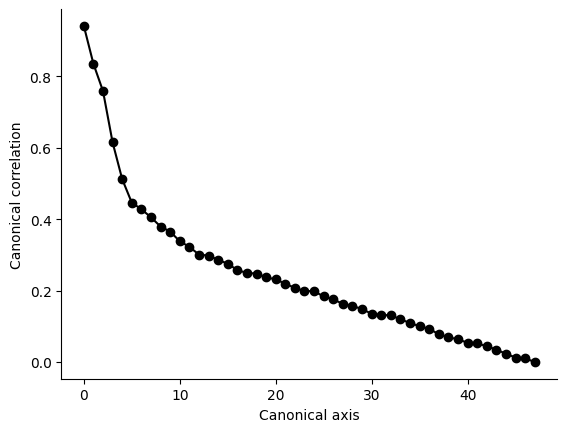

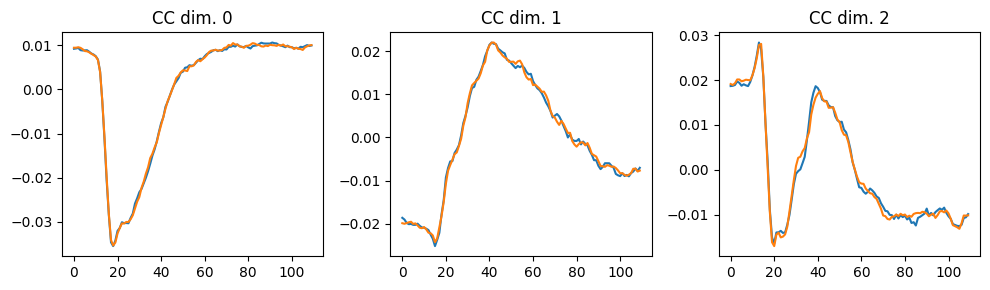

In [43]:

print('Input:', X1_tr.T.shape, X2_tr.T.shape)
axes_area_1, axes_area_2, A_1_tr, A_2_tr, cc = cca_helpers.align(X1_tr.T, X2_tr.T, m=keep_pcs, cv=False)
cc = np.asarray(cc)
#print(axes_area_1.shape, axes_area_2.shape, A_1.shape, A_2.shape, cc.shape)

A_1_te = X1_te.T @ axes_area_1
A_2_te = X2_te.T @ axes_area_2

print('Output train', A_1_tr.shape, A_2_tr.shape)
print('Output test', A_1_te.shape, A_2_te.shape)

fig, ax = plt.subplots(1,1)
remove_top_right_frame(ax)

ax.plot(cc, marker='o', c='k')
ax.set_xlabel('Canonical axis')
ax.set_ylabel('Canonical correlation')


#A_1 = X_1.T @ axes_area_1
#A_2 = X_2.T @ axes_area_2
print('Post-align shapes:')
print('Train', A_1_tr.shape, A_2_tr.shape)
print('Test', A_1_te.shape, A_2_te.shape)

A_1_trials = A_1_tr.reshape(n_trials, -1, A_1_tr.shape[1])
A_2_trials = A_2_tr.reshape(n_trials, -1, A_2_tr.shape[1])

print('Post-align reshape:')
print(A_1_trials.shape, A_2_trials.shape)

fig, axs = plt.subplots(1,3, figsize=(10,3), sharex=False, sharey=False)
for cc_dim in range(3):
    axs[cc_dim].set_title('CC dim. {}'.format(cc_dim))
    axs[cc_dim].plot(np.mean(A_1_trials, axis=0)[:,cc_dim])
    axs[cc_dim].plot(np.mean(A_2_trials, axis=0)[:,cc_dim])
plt.tight_layout()

### Compare trial-averaged trajectories between areas
- Comparing PCA (unaligned axes) and CCA (aligned axes)

In [50]:
P_1_trials = P_1_te.reshape(n_trials, -1, P_1_te.shape[1])
P_2_trials = P_2_te.reshape(n_trials, -1, P_2_te.shape[1])
print(P_1_trials.shape)

P_1_trials_mean = np.mean(P_1_trials,axis=0)
P_2_trials_mean = np.mean(P_2_trials,axis=0)
print(P_1_trials_mean.shape)


A_1_trials = A_1_te.reshape(n_trials, -1, A_1_te.shape[1])
A_2_trials = A_2_te.reshape(n_trials, -1, A_2_te.shape[1])

A_1_trials_mean = np.mean(A_1_trials,axis=0)
A_2_trials_mean = np.mean(A_2_trials,axis=0)
n_time_bins = A_1_trials_mean.shape[0]

(41, 110, 166)
(110, 166)


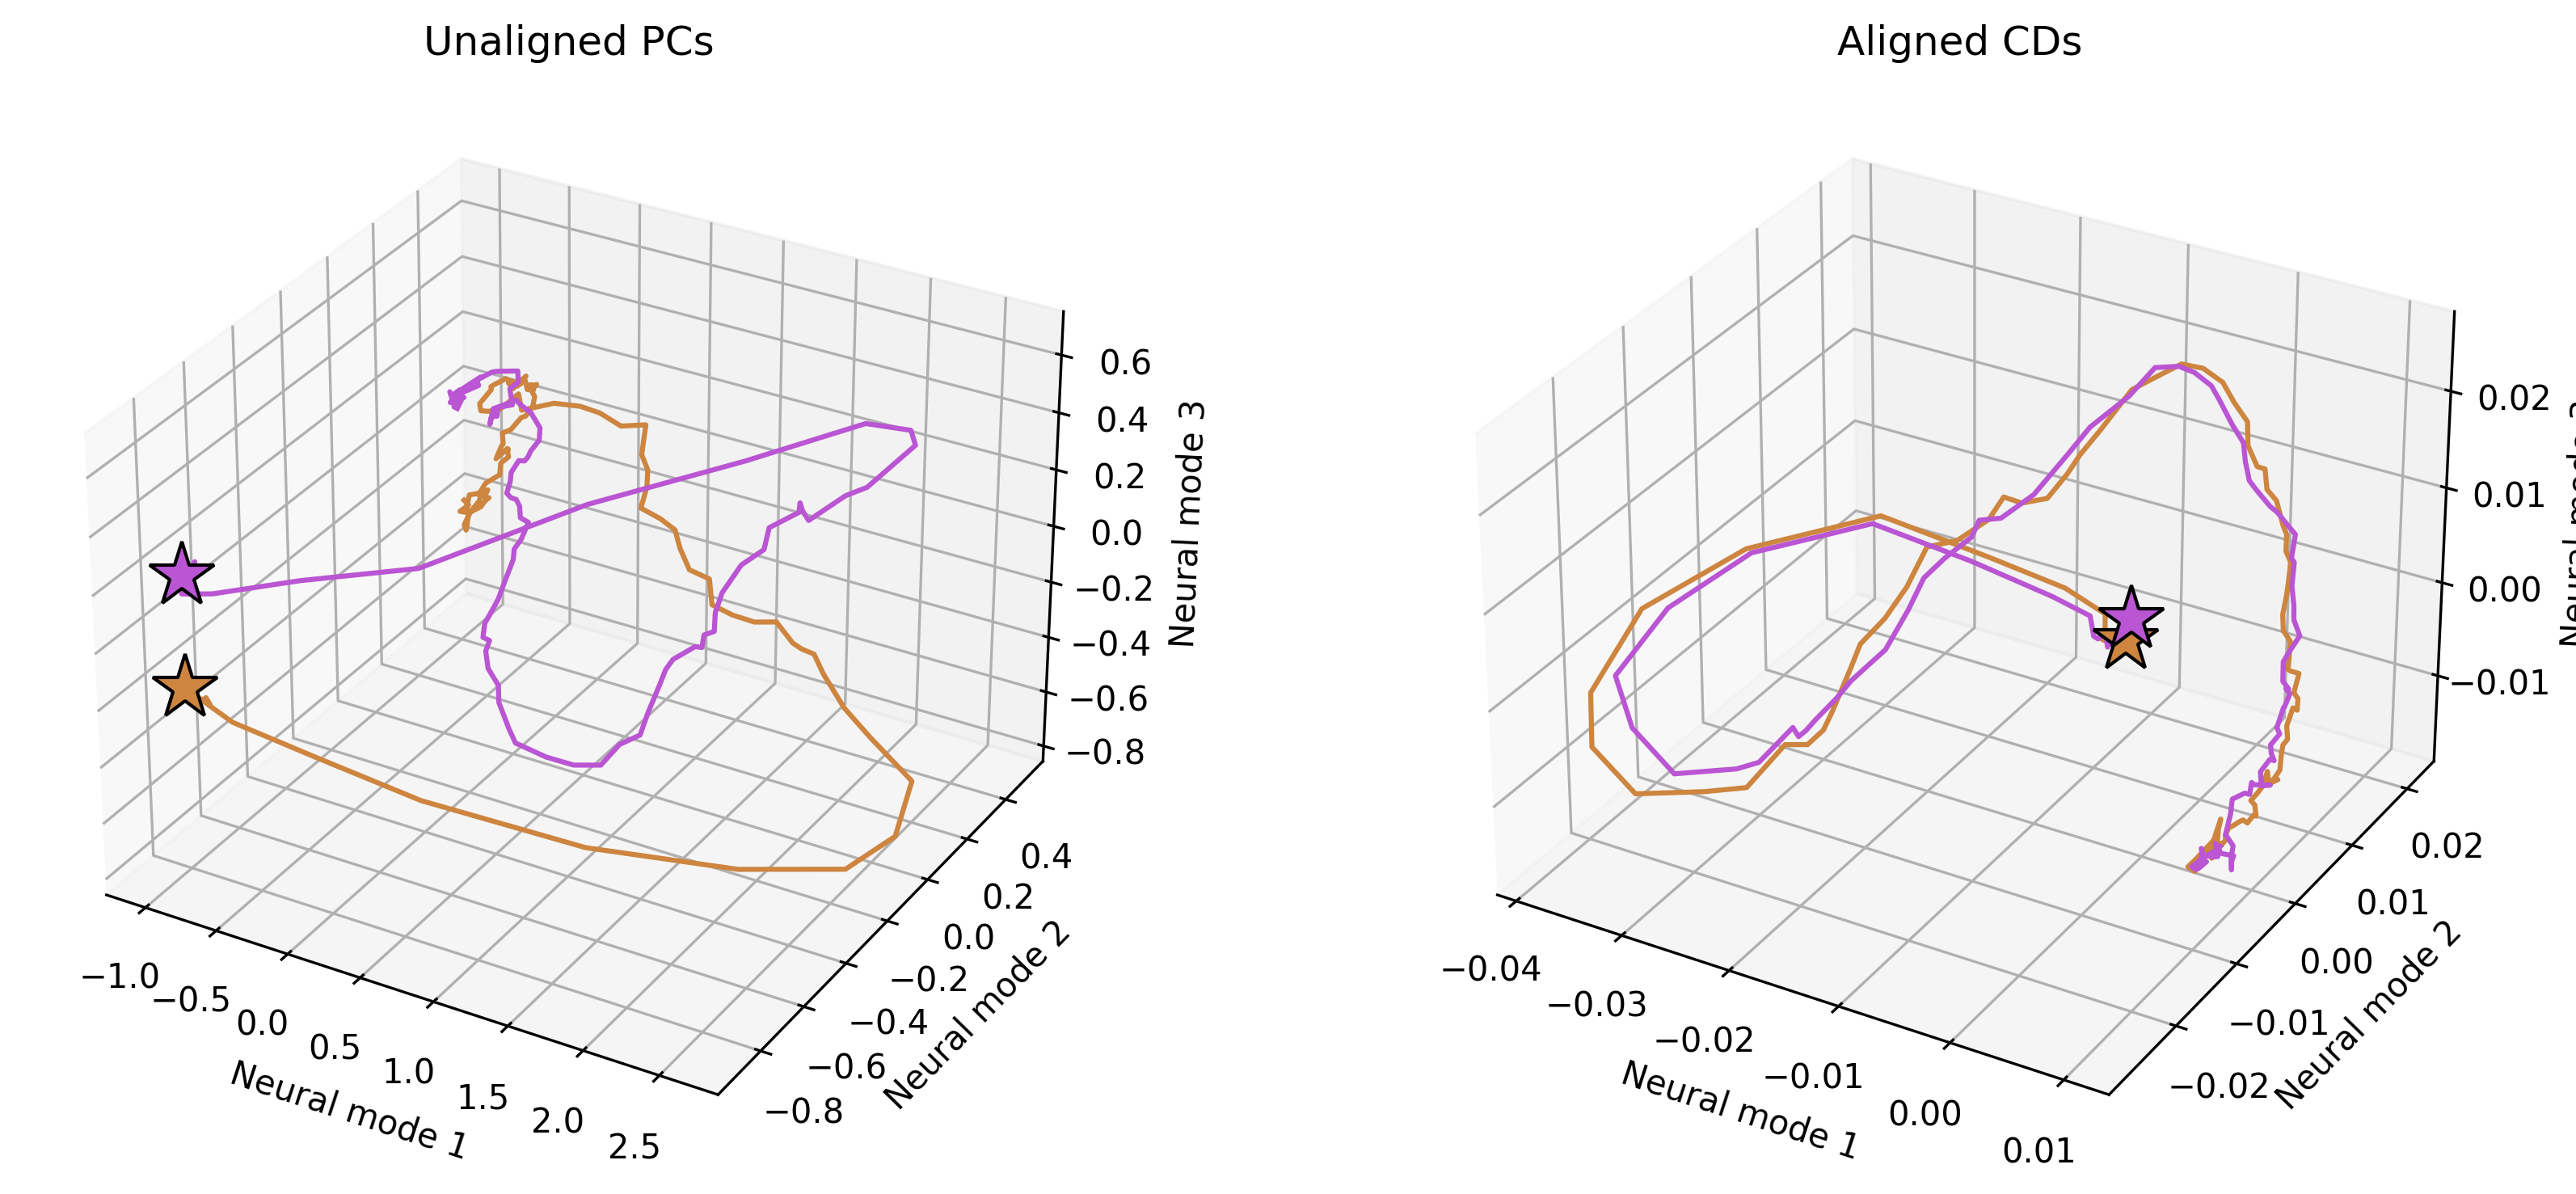

In [63]:
fig, axs = plt.subplots(1,2, figsize=(12,5), dpi=300, subplot_kw={'projection': '3d'})
for ax in axs.flat:
    ax.set_xlabel('Neural mode 1')
    ax.set_ylabel('Neural mode 2')
    ax.set_zlabel('Neural mode 3')
    remove_top_right_frame(ax)

axs[0].set_title('Unaligned PCs')


# Trajectories of trial-averages
axs[0].plot(P_1_trials_mean[:,0], 
          P_1_trials_mean[:,1], 
          P_1_trials_mean[:,2],
          color = get_area_color(area_1))

axs[0].plot(P_2_trials_mean[:,0], 
          P_2_trials_mean[:,1], 
          P_2_trials_mean[:,2],
          color = get_area_color(area_2))

# Starting points
axs[0].plot(P_1_trials_mean[0,0], 
          P_1_trials_mean[0,1], 
          P_1_trials_mean[0,2],
          color = get_area_color(area_1),
          marker='*',
          mec='k',
          ms=20)

axs[0].plot(P_2_trials_mean[0,0], 
          P_2_trials_mean[0,1], 
          P_2_trials_mean[0,2],
          color = get_area_color(area_2),
          marker='*',
          mec='k',
          ms=20)

axs[1].set_title('Aligned CDs')


# Trajectories of trial-averages
axs[1].plot(A_1_trials_mean[:,0], 
          A_1_trials_mean[:,1], 
          A_1_trials_mean[:,2],
          color = get_area_color(area_1))

axs[1].plot(A_2_trials_mean[:,0], 
          A_2_trials_mean[:,1], 
          A_2_trials_mean[:,2],
          color = get_area_color(area_2))

# Starting points
axs[1].plot(A_1_trials_mean[0,0], 
          A_1_trials_mean[0,1], 
          A_1_trials_mean[0,2],
          color = get_area_color(area_1),
          marker='*',
          mec='k',
          ms=20)

axs[1].plot(A_2_trials_mean[0,0], 
          A_2_trials_mean[0,1], 
          A_2_trials_mean[0,2],
          color = get_area_color(area_2),
          marker='*',
          mec='k',
          ms=20)


plt.tight_layout()